In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.optimize import curve_fit

### Experimental results

In [2]:
def get_average_curve(fname):
    data = pd.read_csv('../results/'+fname)
    data.columns = [int(x) for x in data.columns]
    data.index = [int(x) for x in data.index]
    fil = data.isna().sum() == 0
    data = data[data.columns[fil]]
    t = data[0][1:].astype(float)
    conditions = list(data.loc[0].unique())
    conditions.remove('Time (min)')
    results = pd.DataFrame(index=t, columns=conditions)
    meta = pd.DataFrame(index=conditions, columns=['cpd', 'dose'])
    for c in conditions:
        fil = data.loc[0] == c
        results[c] = data[data.columns[fil.values]].iloc[1:].astype(float).mean(1).values
    for i in meta.index:
        cpd = i.split()[0]
        try:
            dose = float(i.split()[1].replace(',', '.'))
        except IndexError:
            dose = np.nan
        meta.loc[i] = cpd, dose
    return results, meta

In [3]:
def get_x(fname, t0=0.1, t1=30, arrestin=1, mock=1):
    curve, meta = get_average_curve(fname)
    fil = np.in1d(meta['cpd'], ['AngII', 'AngIV', 'TRV055', 'TRV056'])
    meta = meta[fil]
    curve = curve[meta.index]
    fil = (curve.index>t0) & (curve.index<t1)
    curve = curve[fil].mean()
    curve = curve / curve.max()
    X = pd.DataFrame(columns=curve.index)
    X.loc['y'] = curve
    X.loc['d'] = meta['dose']

    X.loc['a2_a_m'] = (meta['cpd'] == 'AngII') * arrestin * mock
    X.loc['a2_a_d'] = (meta['cpd'] == 'AngII') * arrestin * (1-mock)
    X.loc['a2_g_m'] = (meta['cpd'] == 'AngII') * (1-arrestin) * mock
    X.loc['a2_g_d'] = (meta['cpd'] == 'AngII') * (1-arrestin) * (1-mock)
    X.loc['a2_k'] = (meta['cpd'] == 'AngII') * 1

    X.loc['a4_a_m'] = (meta['cpd'] == 'AngIV') * arrestin * mock
    X.loc['a4_a_d'] = (meta['cpd'] == 'AngIV') * arrestin * (1-mock)
    X.loc['a4_g_m'] = (meta['cpd'] == 'AngIV') * (1-arrestin) * mock
    X.loc['a4_g_d'] = (meta['cpd'] == 'AngIV') * (1-arrestin) * (1-mock)
    X.loc['a4_k'] = (meta['cpd'] == 'AngIV') * 1

    X.loc['t55_a_m'] = (meta['cpd'] == 'TRV055') * arrestin * mock
    X.loc['t55_a_d'] = (meta['cpd'] == 'TRV055') * arrestin * (1-mock)
    X.loc['t55_g_m'] = (meta['cpd'] == 'TRV055') * (1-arrestin) * mock
    X.loc['t55_g_d'] = (meta['cpd'] == 'TRV055') * (1-arrestin) * (1-mock)
    X.loc['t55_k'] = (meta['cpd'] == 'TRV055') * 1

    X.loc['t56_a_m'] = (meta['cpd'] == 'TRV056') * arrestin * mock
    X.loc['t56_a_d'] = (meta['cpd'] == 'TRV056') * arrestin * (1-mock)
    X.loc['t56_g_m'] = (meta['cpd'] == 'TRV056') * (1-arrestin) * mock
    X.loc['t56_g_d'] = (meta['cpd'] == 'TRV056') * (1-arrestin) * (1-mock)
    X.loc['t56_k'] = (meta['cpd'] == 'TRV056') * 1
    X.columns = [str(arrestin) + '_' + str(mock) + '_' + x for x in X.columns]
    return X

In [4]:
def operation_model(X,
                   a2am, a2ad, a2gm, a2gd, a2k,
                   a4am, a4ad, a4gm, a4gd, a4k,
                   t5am, t5ad, t5gm, t5gd, t5k,
                   t6am, t6ad, t6gm, t6gd, t6k):
    a = X[0]
    ta2 = X[1] * a2am + X[2] * a2ad + X[3] * a2gm + X[4] * a2gd
    ka2 = X[5] * a2k
    
    ta4 = X[6] * a4am + X[7] * a4ad + X[8] * a4gm + X[9] * a4gd
    ka4 = X[10] * a4k
    
    tt5 = X[11] * t5am + X[12] * t5ad + X[13] * t5gm + X[14] * t5gd
    kt5 = X[15] * t5k
    
    tt6 = X[16] * t6am + X[17] * t6ad + X[18] * t6gm + X[19] * t6gd
    kt6 = X[20] * t6k
    
    t = ta2 + ta4 + tt5 + tt6
    k = ka2 + ka4 + kt5 + kt6
    
    return (t/k * a) / (t/k * a + a/k + 1)

In [5]:
def get_bias(gq='gq', t0=0.1, t1=25):
    X_arrestin_mock = get_x('../results/arrestin.csv', t0=t0, t1=t1, arrestin=1, mock=1)
    X_arrestin_dyn = get_x('../results/arrestin-dyn.csv', t0=t0, t1=t1, arrestin=1, mock=0)
    X_gq_mock = get_x('../results/%s.csv' % gq, t0=t0, t1=t1, arrestin=0, mock=1)
    X_gq_dyn = get_x('../results/%s-dyn.csv' % gq, t0=t0, t1=t1, arrestin=0, mock=0)
    X = pd.concat([X_arrestin_dyn, X_arrestin_mock, X_gq_dyn, X_gq_mock], axis=1)
    X.loc['d'] = 10**X.loc['d'] * 10**8
    y = X.loc['y'].values
    X = X.iloc[1:].values
    coefs, stds = curve_fit(operation_model, X, y, bounds=(np.array([0.0]*20), np.array([1000.0]*20)))
    stds = np.sqrt(np.diag(stds))
    coefs = pd.DataFrame(coefs.reshape(4, 5), index=['AngII', 'AngIV', 'TRV055', 'TRV056'],
                 columns=['tau_arrestin_mock', 'tau_arrestin_dyn', 'tau_gq_mock', 'tau_gq_dyn', 'kd'])
    stds = pd.DataFrame(stds.reshape(4, 5), index=['AngII', 'AngIV', 'TRV055', 'TRV056'],
                 columns=['tau_arrestin_mock', 'tau_arrestin_dyn', 'tau_gq_mock', 'tau_gq_dyn', 'kd'])
    coefs_return, stds_return = coefs.copy(), stds.copy()
    kd = coefs['kd'] / 10**8
    coefs = coefs.iloc[:, :-1]
    coefs = np.log10(coefs.T / kd)
    coefs = coefs.T - coefs['AngII']
    bias_mock = coefs['tau_arrestin_mock'] - coefs['tau_gq_mock']
    bias_dyn = coefs['tau_arrestin_dyn'] - coefs['tau_gq_dyn']
    return bias_mock, bias_dyn, coefs_return, stds_return

In [6]:
results_mock = pd.DataFrame(index=['AngII', 'AngIV', 'TRV055', 'TRV056'], columns=[0, 5, 10, 15, 20])
results_dyn = pd.DataFrame(index=['AngII', 'AngIV', 'TRV055', 'TRV056'], columns=[0, 5, 10, 15, 20])
for i in results_mock.columns:
    bias_mock, bias_dyn, coefs, stds = get_bias(t0=i+0.1, t1=i+5)
    results_mock.loc[bias_mock.index, i] = bias_mock
    results_dyn.loc[bias_dyn.index, i] = bias_dyn

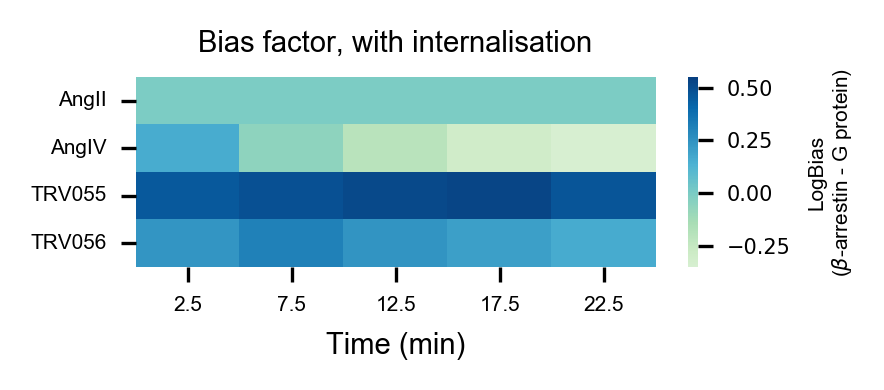

In [26]:
data = results_mock.astype(float)
f = plt.figure(figsize=(3.0, 1.4), dpi=300)
ax = sns.heatmap(data, cmap='GnBu', center=0, vmin=-0.35, vmax=0.55)
ax.set_yticklabels(results_mock.index, fontsize=5, fontname='Arial', rotation=0)
ax.set_xticklabels([x + 2.5 for x in results_mock.columns], fontsize=5, fontname='Arial')
plt.title('Bias factor, with internalisation', fontsize=7, fontname='Arial')
plt.xlabel('Time (min)', fontsize=7, fontname='Arial')
cbar = ax.collections[0].colorbar
cbar.set_label(r'LogBias'+'\n'+r'($\beta$-arrestin - G protein)', 
               fontsize=5, fontname='Arial')
cbar.ax.yaxis.set_tick_params(labelsize=5)
plt.tight_layout()
plt.savefig('../results/exp-fit-gq-int.pdf')

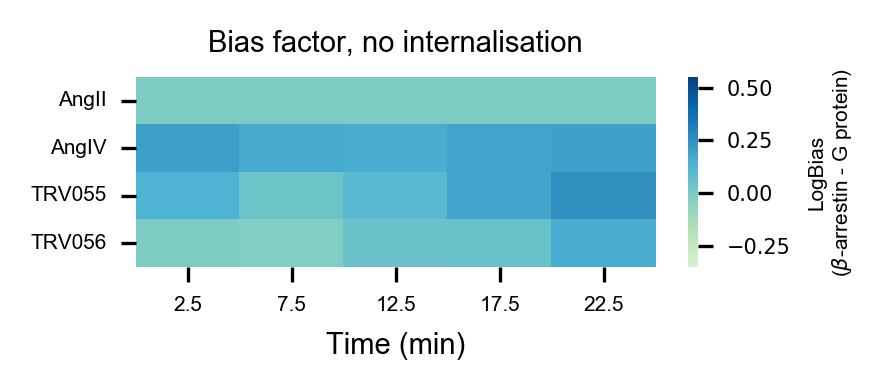

In [27]:
data = results_dyn.astype(float)
f = plt.figure(figsize=(3.0, 1.4), dpi=300)
ax = sns.heatmap(data, cmap='GnBu', center=0, vmin=-0.35, vmax=0.55)
ax.set_yticklabels(results_mock.index, fontsize=5, fontname='Arial', rotation=0)
ax.set_xticklabels([x + 2.5 for x in results_mock.columns], fontsize=5, fontname='Arial')
plt.title('Bias factor, no internalisation', fontsize=7, fontname='Arial')
plt.xlabel('Time (min)', fontsize=7, fontname='Arial')
cbar = ax.collections[0].colorbar
cbar.set_label(r'LogBias'+'\n'+r'($\beta$-arrestin - G protein)', 
               fontsize=5, fontname='Arial')
cbar.ax.yaxis.set_tick_params(labelsize=5)
plt.tight_layout()
plt.savefig('../results/exp-fit-gq-noint.pdf')

### Simulation results

In [28]:
def get_average_curve(fname):
    data1 = pd.read_csv('../data/simulation/high-koff-%s.csv' % fname, index_col=0)
    data1.columns = [int(float(x)) for x in data1.columns]
    data1 = data1.T
    data2 = pd.read_csv('../data/simulation/low-koff-%s.csv' % fname, index_col=0)
    data2.columns = [int(float(x)) for x in data2.columns]
    data2 = data2.T
    data1.columns = ['high_koff ' + str(x) for x in data1.columns]
    data2.columns = ['low_koff ' + str(x) for x in data2.columns]
    data = pd.concat([data1, data2], axis=1)
    meta = pd.DataFrame(index=data.columns, columns=['cpd', 'dose'])
    meta['cpd'] = pd.Series(meta.index).apply(lambda x: x.split()[0]).values
    meta['dose'] = pd.Series(meta.index).apply(lambda x: float(x.split()[1])).values
    return data, meta

In [29]:
def get_x(fname, t, arrestin=1, mock=1):
    curve, meta = get_average_curve(fname)
    curve = curve.loc[t]
    curve = curve / curve.max()
    X = pd.DataFrame(columns=curve.index)
    X.loc['y'] = curve
    X.loc['d'] = meta['dose']

    X.loc['h_a_m'] = (meta['cpd'] == 'high_koff') * arrestin * mock
    X.loc['h_a_d'] = (meta['cpd'] == 'high_koff') * arrestin * (1-mock)
    X.loc['h_g_m'] = (meta['cpd'] == 'high_koff') * (1-arrestin) * mock
    X.loc['h_g_d'] = (meta['cpd'] == 'high_koff') * (1-arrestin) * (1-mock)
    X.loc['h_k'] = (meta['cpd'] == 'high_koff') * 1

    X.loc['l_a_m'] = (meta['cpd'] == 'low_koff') * arrestin * mock
    X.loc['l_a_d'] = (meta['cpd'] == 'low_koff') * arrestin * (1-mock)
    X.loc['l_g_m'] = (meta['cpd'] == 'low_koff') * (1-arrestin) * mock
    X.loc['l_g_d'] = (meta['cpd'] == 'low_koff') * (1-arrestin) * (1-mock)
    X.loc['l_k'] = (meta['cpd'] == 'low_koff') * 1

    X.columns = [str(arrestin) + '_' + str(mock) + '_' + x for x in X.columns]
    return X

In [30]:
def operation_model(X,
                   ham, had, hgm, hgd, hk,
                   lam, lad, lgm, lgd, lk):
    a = X[0]
    th = X[1] * ham + X[2] * had + X[3] * hgm + X[4] * hgd
    kh = X[5] * hk 
    
    tl = X[6] * lam + X[7] * lad + X[8] * lgm + X[9] * lgd
    kl = X[10] * lk
    
    
    t = th + tl
    k = kh + kl
    
    return (t/k * a) / (t/k * a + a/k + 1)

In [78]:
def get_bias(t=1200):
    X_arrestin_mock = get_x('arrestin', t, arrestin=1, mock=1)
    X_arrestin_dyn = get_x('arrestin-noint', t, arrestin=1, mock=1)
    X_gq_mock = get_x('gprot', t, arrestin=1, mock=1)
    X_gq_dyn = get_x('gprot-noint', t, arrestin=1, mock=1)
    X = pd.concat([X_arrestin_dyn, X_arrestin_mock, X_gq_dyn, X_gq_mock], axis=1)
    X.loc['d'] = 10**X.loc['d'] * 10**8
    y = X.loc['y'].values
    X = X.iloc[1:].values
    coefs, stds = curve_fit(operation_model, X, y,  bounds = (np.array([0.0]*10),
                                                             np.array([1000, 1000, 1000, 1000, 1000]*2)))
    stds = np.sqrt(np.diag(stds))
    coefs = pd.DataFrame(coefs.reshape(2, 5), index=['high koff', 'low koff'],
                 columns=['tau_arrestin_mock', 'tau_arrestin_dyn', 'tau_gq_mock', 'tau_gq_dyn', 'kd'])
    stds = pd.DataFrame(stds.reshape(2, 5), index=['high koff', 'low koff'],
                 columns=['tau_arrestin_mock', 'tau_arrestin_dyn', 'tau_gq_mock', 'tau_gq_dyn', 'kd'])
    coefs_return, stds_return = coefs.copy(), stds.copy()
    kd = coefs['kd'] / 10**8
    coefs = coefs.iloc[:, :-1]
    coefs = np.log10(coefs.T / kd)
    coefs = coefs.T - coefs['low koff']
    bias_mock = coefs['tau_arrestin_mock'] - coefs['tau_gq_mock']
    bias_dyn = coefs['tau_arrestin_dyn'] - coefs['tau_gq_dyn']
    return bias_mock, bias_dyn, coefs_return, stds_return

In [79]:
results_mock = pd.DataFrame(index=['high koff', 'low koff'], columns=[10, 30,100, 300, 600, 900, 1200])
results_dyn = pd.DataFrame(index=['high koff', 'low koff'], columns=[10, 30, 100, 300, 600, 900, 1200])
for t in results_mock.columns:
    bias_mock, bias_dyn, coefs, stds = get_bias(t)
    results_mock.loc[bias_mock.index, t] = bias_mock
    results_dyn.loc[bias_dyn.index, t] = bias_dyn

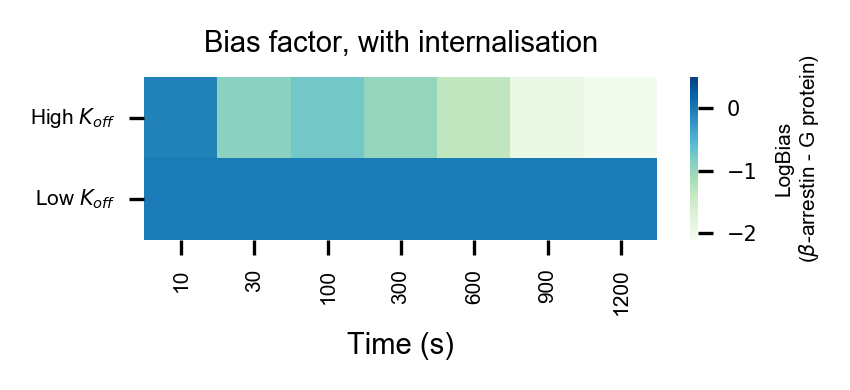

In [85]:
f = plt.figure(figsize=(3.0, 1.4), dpi=300)
ax = sns.heatmap(results_mock.astype(float), cmap='GnBu', vmax=0.5, vmin=-2.1)
ax.set_yticklabels([r'High $K_{off}$', r'Low $K_{off}$'], fontsize=5, fontname='Arial', rotation=0)
ax.set_xticklabels(results_mock.columns, fontsize=5, fontname='Arial')
plt.title('Bias factor, with internalisation', fontsize=7, fontname='Arial')
plt.xlabel('Time (s)', fontsize=7, fontname='Arial')
cbar = ax.collections[0].colorbar
cbar.set_label(r'LogBias'+'\n'+r'($\beta$-arrestin - G protein)',
               fontsize=5, fontname='Arial')
cbar.ax.yaxis.set_tick_params(labelsize=5)
plt.tight_layout()
#plt.savefig('../results/sum-fit-int.pdf')

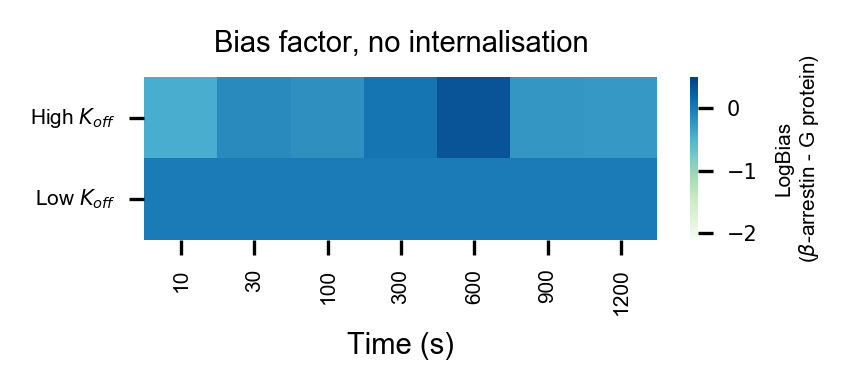

In [86]:
f = plt.figure(figsize=(3.0, 1.4), dpi=300)
ax = sns.heatmap(results_dyn.astype(float), cmap='GnBu', vmax=0.5, vmin=-2.1)
ax.set_yticklabels([r'High $K_{off}$', r'Low $K_{off}$'], fontsize=5, fontname='Arial', rotation=0)
ax.set_xticklabels(results_mock.columns, fontsize=5, fontname='Arial')
plt.title('Bias factor, no internalisation', fontsize=7, fontname='Arial')
plt.xlabel('Time (s)', fontsize=7, fontname='Arial')
cbar = ax.collections[0].colorbar
cbar.set_label(r'LogBias'+'\n'+r'($\beta$-arrestin - G protein)',
               fontsize=5, fontname='Arial')
cbar.ax.yaxis.set_tick_params(labelsize=5)
plt.tight_layout()
plt.savefig('../results/sum-fit-noint.pdf')